# <span style='color:red'> Fully Connected Neural Network Example on Iris Classification - Cross Entropy Loss </span>
# <span style='color:blue'> by Jimin Kim </span>

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import numpy as np

# <span style='color:red'> Part 2: Additional Data Prep Methods ----------------------------------------------------------</span>

### 2.1 - One-hot Encoding

In [13]:
# Each integer corresponding to a label

labels = torch.tensor([0,1,2]) 
print(labels)

tensor([0, 1, 2])


In [14]:
# Using torch.nn.functional.one_hot() to convert the integer labels to one-hot encoding

labels_one_hot = torch.nn.functional.one_hot(labels) 
print(labels_one_hot)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])


# <span style='color:red'> Part 5: Training FCN (Iris Classification example) -------------------------------------------</span>

### Prepare Data

In [15]:
# Import necessary functions from scikit-learn library
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# iris dataset is available from scikit-learn package
iris = load_iris()

# Load the X (features) and y (targets) for training
X = iris['data']
y = iris['target']

# Scale the input dataset X with standard scaling using scikit-learn
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset with training (80%) and testing (20%) using train_test_split from scikit_learn
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

# We will additionally split the training data into training and validation
# The final split ratios are training: 60%, validation: 20% and testing 20%
X_validation = X_train[:int(len(X_test))]
y_validation = y_train[:int(len(X_test))]

X_train = X_train[int(len(X_test)):]
y_train = y_train[int(len(X_test)):]

In [6]:
X_train.shape

(90, 4)

### Define Model

In [16]:
class irisClassificationFCN(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden1_dim, hidden2_dim):# Add parameters for dimensions of 2 hidden layers 
        
        super(irisClassificationFCN, self).__init__()
        
        self.layer1 = torch.nn.Linear(input_dim, hidden1_dim)    # Connections from input to hidden layer 1
        self.layer2 = torch.nn.Linear(hidden1_dim, hidden2_dim)  # Connections from hidden layer 1 to hidden layer 2
        self.layer3 = torch.nn.Linear(hidden2_dim, output_dim)   # Connections from hidden layer 2 to final output
        
    def forward(self, x):
        
        out1 = torch.nn.functional.relu(self.layer1(x))          # Apply relu activation to layer 1 output
        out2 = torch.nn.functional.relu(self.layer2(out1))       # Apply relu activation to layer 2 output
        # CrossEntropyLoss will apply the softmax by itself so you can use raw output. 
        # Here softmax is used just that you will be able to inspect the values and
        # see that these correpond to probabilities
        # output = torch.nn.functional.softmax(self.layer3(out2) , dim=1)    # Return raw layer 3 output
        output = self.layer3(out2)    # Return raw layer 3 output
        
        return output

### Define Hyperparameters

In [17]:
# Initialize our neural network model with input, output and hidden layer dimensions
model = irisClassificationFCN(input_dim = 4, output_dim = 3, hidden1_dim = 30, hidden2_dim = 10)

# Define the learning rate and epoch
# learning_rate = 0.025
learning_rate = 0.3
# epochs = 80

epochs = 180


# Define loss function (CrossEntropyLoss) and optimizer (Adam)
loss_func = torch.nn.CrossEntropyLoss() # Using cross entropy loss since we are outputing probabilities
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # Using Adam for more effective optimization

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model

irisClassificationFCN(
  (layer1): Linear(in_features=4, out_features=30, bias=True)
  (layer2): Linear(in_features=30, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
)

### Identify Tracked Values

In [18]:
# Placeholders for training loss and validation accuracy during training

train_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

In [19]:
X_train.shape

(90, 4)

### Train Model

In [22]:
import tqdm # For keeping track of our training progress in percentage

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

train_inputs = torch.from_numpy(X_train).float()
train_targets = torch.from_numpy(y_train).long() # Convert to 64-bit integer



validation_inputs = torch.from_numpy(X_validation).float()
validation_targets = torch.from_numpy(y_validation).long()

testing_inputs = torch.from_numpy(X_test).float()
testing_targets = torch.from_numpy(y_test).long()

# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):
    
    optimizer.zero_grad()
    
    train_outputs = model(train_inputs)
    print(train_outputs)    
    print(train_targets)
    loss = loss_func(train_outputs, train_targets)
    
    train_loss_list[epoch] = loss.item()
    
    loss.backward()
    
    optimizer.step()
    
    # Compute Validation Accuracy ----------------------------------------------------------------------
    
    with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
        
        # Pass the validation feature data (30 samples) to the network
        validation_outputs = model(validation_inputs)
        
        # validation_outputs = tensor of shape (30, 3), i.e., 30 predictions and each prediction has 3 probabilities.
        # These are classification probabilities for each flower type: [p(setosa), p(versicolor), p(virginica)].
        # torch.argmax(validation_outputs, dim=1) finds the index with the maximum value alongside the column direction
        # i.e. for each sample, it finds the column index with the highest probability.
        # == validation_targets compares these indices with groundtruth validation target labels for each sample
        # For each sample, it returns True if the index matches the target, False otherwise
        # .type(torch.FloatTensor) converts True = 1, False = 0
        # Finally .mean() gives us (Total count of 1) / (Length of the 1D tensor), giving us the classification accuracy  
        
        correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
        validation_accuracy_list[epoch] = correct.mean()

 14%|█▍        | 26/180 [00:00<00:01, 130.84it/s]

tensor([[  5.3307,  -1.2320,  -6.4243],
        [ -5.0906,   0.4858,   4.4974],
        [ -2.3741,   6.3364,  -4.5165],
        [ -2.1581,   6.3962,  -4.9029],
        [ -8.8931,  -3.7113,  12.8463],
        [ -5.2345,   0.7634,   4.3676],
        [ -2.7126,   6.3310,  -4.0402],
        [  7.4340,  -3.7858,  -6.4818],
        [ -2.8035,   6.3523,  -3.9165],
        [  7.9776,  -3.6789,  -7.3806],
        [ -5.7896,  -2.8156,   8.6276],
        [ -3.0478,   7.6988,  -5.2156],
        [ -1.8095,   6.9724,  -6.0272],
        [  7.0010,  -2.7469,  -7.0732],
        [ -3.2432,   8.9430,  -6.4000],
        [ -2.3241,   4.8451,  -2.8324],
        [ -3.8987,   3.9290,  -0.2570],
        [ -9.5653,  -3.5130,  13.3509],
        [  4.9003,  -0.5346,  -6.6319],
        [ -3.0197,   4.3387,  -1.6202],
        [  7.9384,  -4.1430,  -6.7818],
        [ -2.5959,   7.0377,  -5.0637],
        [ -6.8676,  -2.9721,   9.8969],
        [  5.4236,  -1.2191,  -6.5698],
        [ -4.0508,  11.0315,  -7.7282],


 30%|███       | 54/180 [00:00<00:00, 134.94it/s]

tensor([[  5.4539,  -1.2166,  -6.5923],
        [ -5.1200,   0.5099,   4.5020],
        [ -2.3816,   6.5141,  -4.6996],
        [ -2.1863,   6.6360,  -5.1235],
        [ -8.9984,  -3.9057,  13.1529],
        [ -5.2719,   0.7147,   4.4570],
        [ -2.7275,   6.4918,  -4.1943],
        [  7.5837,  -3.8143,  -6.6364],
        [ -2.8222,   6.5445,  -4.1033],
        [  8.1292,  -3.5987,  -7.6568],
        [ -5.8320,  -2.9412,   8.7977],
        [ -3.0769,   7.9708,  -5.4786],
        [ -1.8274,   7.2783,  -6.3350],
        [  7.1247,  -2.6335,  -7.3503],
        [ -3.2781,   9.2865,  -6.7253],
        [ -2.3283,   4.9517,  -2.9360],
        [ -3.9337,   4.0250,  -0.3168],
        [ -9.6697,  -3.7539,  13.7102],
        [  5.0141,  -0.4822,  -6.8281],
        [ -3.0435,   4.5150,  -1.7724],
        [  8.0964,  -4.1221,  -7.0015],
        [ -2.6112,   7.2505,  -5.2723],
        [ -6.9428,  -3.1057,  10.1120],
        [  5.5506,  -1.2102,  -6.7351],
        [ -4.1189,  11.5768,  -8.2370],


 49%|████▉     | 89/180 [00:00<00:00, 157.12it/s]

tensor([[  5.5829,  -1.2012,  -6.7671],
        [ -5.1502,   0.5363,   4.5048],
        [ -2.3879,   6.7042,  -4.8974],
        [ -2.2135,   6.8922,  -5.3625],
        [ -9.1033,  -4.1059,  13.4647],
        [ -5.3100,   0.6619,   4.5504],
        [ -2.7355,   6.6575,  -4.3628],
        [  7.7392,  -3.8441,  -6.7966],
        [ -2.8407,   6.7447,  -4.2980],
        [  8.2860,  -3.5107,  -7.9471],
        [ -5.8768,  -3.0790,   8.9816],
        [ -3.0953,   8.2468,  -5.7589],
        [ -1.8438,   7.6074,  -6.6688],
        [  7.2430,  -2.4900,  -7.6527],
        [ -3.3128,   9.6574,  -7.0793],
        [ -2.3314,   5.0568,  -3.0389],
        [ -3.9677,   4.1423,  -0.3997],
        [ -9.7762,  -3.9953,  14.0697],
        [  5.1335,  -0.4283,  -7.0321],
        [ -3.0664,   4.7126,  -1.9476],
        [  8.2601,  -4.1001,  -7.2288],
        [ -2.6275,   7.4776,  -5.4922],
        [ -7.0178,  -3.2432,  10.3310],
        [  5.6835,  -1.2012,  -6.9072],
        [ -4.1842,  12.1642,  -8.7939],


 58%|█████▊    | 105/180 [00:00<00:00, 154.07it/s]

tensor([[  5.7390,  -1.1791,  -6.9812],
        [ -5.1814,   0.5750,   4.4958],
        [ -2.3922,   6.9357,  -5.1423],
        [ -2.2424,   7.2071,  -5.6616],
        [ -9.2186,  -4.3353,  13.8179],
        [ -5.3493,   0.6011,   4.6532],
        [ -2.7390,   6.8578,  -4.5746],
        [  7.9258,  -3.8798,  -6.9873],
        [ -2.8600,   6.9856,  -4.5350],
        [  8.4730,  -3.3895,  -8.3096],
        [ -5.9267,  -3.2476,   9.2021],
        [ -3.1203,   8.5852,  -6.0921],
        [ -1.8601,   8.0155,  -7.0867],
        [  7.3828,  -2.2976,  -8.0331],
        [ -3.3520,  10.1181,  -7.5235],
        [ -2.3307,   5.1878,  -3.1729],
        [ -4.0032,   4.3062,  -0.5285],
        [ -9.8950,  -4.2676,  14.4716],
        [  5.2778,  -0.3580,  -7.2832],
        [ -3.0894,   4.9722,  -2.1857],
        [  8.4556,  -4.0631,  -7.5106],
        [ -2.6450,   7.7573,  -5.7659],
        [ -7.1007,  -3.4030,  10.5816],
        [  5.8446,  -1.1918,  -7.1130],
        [ -4.2592,  12.8972,  -9.4951],


 86%|████████▌ | 155/180 [00:01<00:00, 158.65it/s]

tensor([[  5.8759,  -1.1527,  -7.1759],
        [ -5.2082,   0.6062,   4.4904],
        [ -2.3943,   7.1442,  -5.3647],
        [ -2.2622,   7.4880,  -5.9358],
        [ -9.3176,  -4.5472,  14.1355],
        [ -5.3834,   0.5465,   4.7436],
        [ -2.7398,   7.0385,  -4.7683],
        [  8.0855,  -3.8941,  -7.1677],
        [ -2.8760,   7.2040,  -4.7513],
        [  8.6365,  -3.2768,  -8.6324],
        [ -5.9721,  -3.4058,   9.4068],
        [ -3.1418,   8.8876,  -6.3867],
        [ -1.8703,   8.3807,  -7.4652],
        [  7.5043,  -2.1185,  -8.3753],
        [ -3.3831,  10.5345,  -7.9291],
        [ -2.3258,   5.3001,  -3.2928],
        [ -4.0318,   4.4545,  -0.6487],
        [ -9.9949,  -4.5175,  14.8309],
        [  5.4059,  -0.3020,  -7.4981],
        [ -3.1068,   5.2048,  -2.4022],
        [  8.6265,  -4.0280,  -7.7590],
        [ -2.6581,   8.0087,  -6.0148],
        [ -7.1728,  -3.5522,  10.8093],
        [  5.9870,  -1.1882,  -7.2888],
        [ -4.3213,  13.5423, -10.1119],


 95%|█████████▌| 171/180 [00:01<00:00, 149.31it/s]

tensor([[  6.0179,  -1.1242,  -7.3783],
        [ -5.2326,   0.6297,   4.4903],
        [ -2.3936,   7.3556,  -5.5933],
        [ -2.2787,   7.7732,  -6.2181],
        [ -9.4157,  -4.7692,  14.4623],
        [ -5.4151,   0.4806,   4.8434],
        [ -2.7381,   7.2216,  -4.9677],
        [  8.2494,  -3.8878,  -7.3738],
        [ -2.8744,   7.4134,  -4.9811],
        [  8.8042,  -3.1498,  -8.9746],
        [ -6.0176,  -3.5774,   9.6248],
        [ -3.1609,   9.1906,  -6.6835],
        [ -1.8763,   8.7554,  -7.8584],
        [  7.6286,  -1.9216,  -8.7390],
        [ -3.4111,  10.9633,  -8.3514],
        [ -2.3189,   5.4154,  -3.4179],
        [ -4.0583,   4.6088,  -0.7771],
        [-10.0923,  -4.7789,  15.1996],
        [  5.5391,  -0.2432,  -7.7216],
        [ -3.1227,   5.4436,  -2.6268],
        [  8.8018,  -3.9830,  -8.0225],
        [ -2.6686,   8.2651,  -6.2717],
        [ -7.2448,  -3.7102,  11.0456],
        [  6.1346,  -1.1851,  -7.4700],
        [ -4.3792,  14.2058, -10.7515],


100%|██████████| 180/180 [00:01<00:00, 143.41it/s]

tensor([[ 6.1118e+00, -1.1046e+00, -7.5127e+00],
        [-5.2473e+00,  6.3398e-01,  4.5005e+00],
        [-2.3927e+00,  7.4915e+00, -5.7402e+00],
        [-2.2873e+00,  7.9560e+00, -6.4011e+00],
        [-9.4786e+00, -4.9192e+00,  1.4679e+01],
        [-5.4345e+00,  4.2561e-01,  4.9198e+00],
        [-2.7359e+00,  7.3381e+00, -5.0955e+00],
        [ 8.3569e+00, -3.8830e+00, -7.5093e+00],
        [-2.8710e+00,  7.5458e+00, -5.1294e+00],
        [ 8.9143e+00, -3.0627e+00, -9.2031e+00],
        [-6.0476e+00, -3.6980e+00,  9.7759e+00],
        [-3.1717e+00,  9.3860e+00, -6.8764e+00],
        [-1.8775e+00,  8.9983e+00, -8.1160e+00],
        [ 7.7101e+00, -1.7877e+00, -8.9823e+00],
        [-3.4272e+00,  1.1242e+01, -8.6283e+00],
        [-2.3137e+00,  5.4892e+00, -3.4990e+00],
        [-4.0742e+00,  4.7089e+00, -8.6139e-01],
        [-1.0154e+01, -4.9559e+00,  1.5445e+01],
        [ 5.6273e+00, -2.0392e-01, -7.8697e+00],
        [-3.1320e+00,  5.5996e+00, -2.7745e+00],
        [ 8.9170e+00

### Visualize and Evaluate Model

In [11]:
# Import seaborn to make prettier plots

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1.5)
print(validation_accuracy_list)

[0.26666668 0.46666667 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.86666667 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.86666667 0.86666667 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.8999

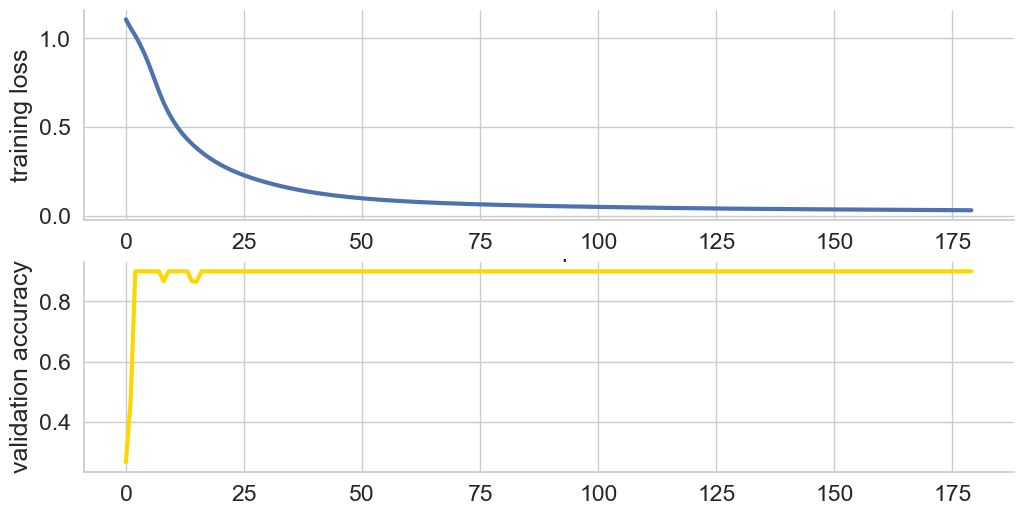

In [12]:
# Plot training loss and validation accuracy throughout the training epochs

plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [13]:
with torch.no_grad():
    
    # Pass the testing feature data (30 samples) to the network to produce model predictions
    y_pred_test = model(testing_inputs) 
    
    # Use the same technique as above to commpute the testing classification accuracy
    correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()*100) + '%')

Testing Accuracy: 93.33333373069763%
